# CORS sampler

In [4]:
import numpy as np
from black_it.loss_functions.msm import MethodOfMomentsLoss

from black_it.search_space import SearchSpace
from black_it.samplers.cors import CORSSampler

import matplotlib.pyplot as plt
from numpy.typing import NDArray
from typing import Sequence
from numpy.random import default_rng
from black_it.samplers.r_sequence import RSequenceSampler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# seed management
_seed = -1
def seed():
    global _seed
    _seed += 1
    return _seed

This notebook illustrates the functioning of the search "CORS" search method, first proposed in

"Regis, Rommel G., and Christine A. Shoemaker. _Constrained global optimization of expensive black box functions using radial basis functions_ Journal of Global optimization 31.1 (2005): 153-171."

## Illustration of the basic principle

Iteration  0
Using radius 0.19947114020071635
Using radius 0.17192250165178827
Using radius 0.15078600877302686
Iteration  1
Using radius 0.11182589701377152
Using radius 0.10165990637615593
Using radius 0.0923371954611859
Iteration  2
Using radius 0.07539300438651343
Using radius 0.06841803664237174
Using radius 0.06155813030745727
Iteration  3
Using radius 0.05082995318807797
Using radius 0.04446436818856912
Using radius 0.037696502193256716
Iteration  4
Using radius 0.028495877171530907
Using radius 0.019799172937140987
Using radius 0.0


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_21791/2393120287.py:50: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(true_params[0], true_params[1], marker="x", s=500, facecolor="red", edgecolors='black', label ='true minimum')


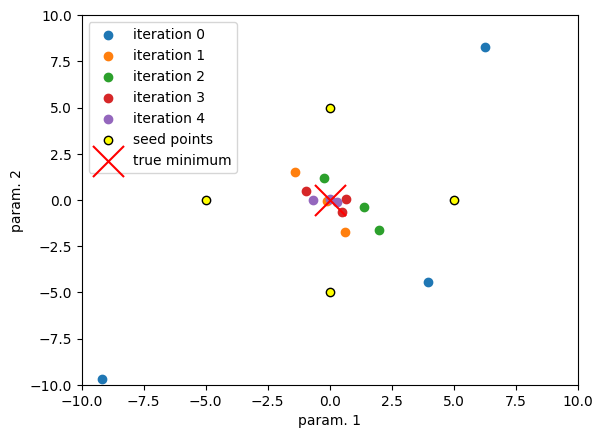

In [24]:
# define a 2-dimensional grid of possible parameter values between 0 and 1.
param_grid = SearchSpace(
    parameters_bounds=np.array([[-10, 10], [-10, 10]]).T,
    parameters_precision=[0.001, 0.001],
    verbose=False,
)

# define a quadratic loss function with global minimum at [0, 0]
def loss_function(parameters: NDArray[np.float64]) -> float:
    return parameters[0]**2 + parameters[1]**2
true_minimum = np.array([0, 0])

# define 4 initial points available to the sampler
all_points = np.array([
    [0.0, 5.0],
    [5.0, 0.0],
    [0.0, -5.0],
    [-5.0, 0.0]
])
# initial values for the losses
all_losses = np.array([loss_function(param) for param in all_points])


# define the size of batch and the number of times to call the sampler
batch_size = 3
nb_iterations = 5
max_samples = batch_size * nb_iterations 
sampler = CORSSampler(batch_size=4, random_state=0, max_samples=max_samples, verbose=True)

# note how the "radius" progressively diminishes giving rise to progressively more 
# "local" sampling around the minimum 
for i in range(nb_iterations):
    print("Iteration ", i)
    new_points = sampler.sample_batch(batch_size, param_grid, all_points, all_losses)
    new_losses = np.array([loss_function(param) for param in new_points])

    all_points = np.concatenate([all_points, new_points])
    all_losses = np.concatenate([all_losses, new_losses])

    plt.scatter(new_points[:, 0], new_points[:, 1], label=f"iteration {i}")

# plot seed
plt.scatter(all_points[:4, 0], all_points[:4, 1], marker="o", facecolor="yellow", edgecolors='black', label="seed points")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel("param. 1")
plt.ylabel("param. 2")

# plot true parameters
plt.scatter(true_params[0], true_params[1], marker="x", s=500, facecolor="red", edgecolors='black', label ='true minimum')

plt.legend()

## General illustration

In [30]:
# define a 2-dimensional grid of possible parameter values between -1 and 1.
param_grid = SearchSpace(
    parameters_bounds=np.array([[-1, 1], [-1, 1]]).T,
    parameters_precision=[0.001, 0.001],
    verbose=False,
)

# compute seed points and their losses
# better to use low-discrepancy sampler (e.g. r-seq) rather than random
nb_seed_points = 10
random_sampler = RSequenceSampler(batch_size, random_state=seed(), max_deduplication_passes=0)
points = random_sampler.sample_batch(nb_seed_points, param_grid, [], [])
losses = np.array([loss_function(point) for point in points])

# define batch size and number of iterations
batch_size = 3
nb_iterations = 10
max_samples = batch_size * nb_iterations 
sampler = CORSSampler(batch_size=batch_size, random_state=seed(), 
                      max_samples=max_samples, verbose=True, 
                      p = 1., rho0 = 0.5)

for i in range(nb_iterations):
    print("Iteration ", i + 1)
    current_batch = sampler.sample(param_grid, points, losses)
    current_losses = []
    for point in current_batch:
        loss = loss_function(point)
        current_losses.append(loss)
    points = np.concatenate([points, current_batch])
    losses = np.concatenate([losses, current_losses])


Iteration  1
Using radius 0.126156626101008
Using radius 0.11819353989651808
Using radius 0.11112258250840244
Iteration  2
Using radius 0.09443603610186138
Using radius 0.08983728334775622
Using radius 0.08554220389903007
Iteration  3
Using radius 0.07574668734920803
Using radius 0.07245335311663377
Using radius 0.06929710527999346
Iteration  4
Using radius 0.0626104822689313
Using radius 0.05996376153708662
Using radius 0.05738345485901364
Iteration  5
Using radius 0.05238368775643533
Using radius 0.05008838581514504
Using radius 0.047819545715844694
Iteration  6
Using radius 0.04382733758825191
Using radius 0.04171486233275142
Using radius 0.03959834587428197
Iteration  7
Using radius 0.036226676558316885
Using radius 0.034171350093588654
Using radius 0.03207832646213627
Iteration  8
Using radius 0.02905724187749581
Using radius 0.02692291946429623
Using radius 0.02469390722408943
Iteration  9
Using radius 0.02175114243120828
Using radius 0.019289237336194216
Using radius 0.016565176

In [31]:
print("Best parameter in seed:        ", points[:nb_seed_points][np.argmin(losses[:nb_seed_points])], np.min(losses[:nb_seed_points]))
print("Best parameter while searching:", points[nb_seed_points:][np.argmin(losses[nb_seed_points:])], np.min(losses[nb_seed_points:]))
print("Global Best parameters:        ", points[np.argmin(losses)], np.min(losses))
best = points[np.argmin(losses)]


Best parameter in seed:         [-0.165 -0.199] 0.06682599999999947
Best parameter while searching: [8.8817842e-16 8.8817842e-16] 1.5777218104420236e-30
Global Best parameters:         [8.8817842e-16 8.8817842e-16] 1.5777218104420236e-30


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_21791/2464658182.py:6: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(true_params[0], true_params[1], marker="x", s=500, facecolor="red", edgecolors='black')
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_21791/2464658182.py:9: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(best[0], best[1], marker="x", s=500, facecolor="green", edgecolors='black')


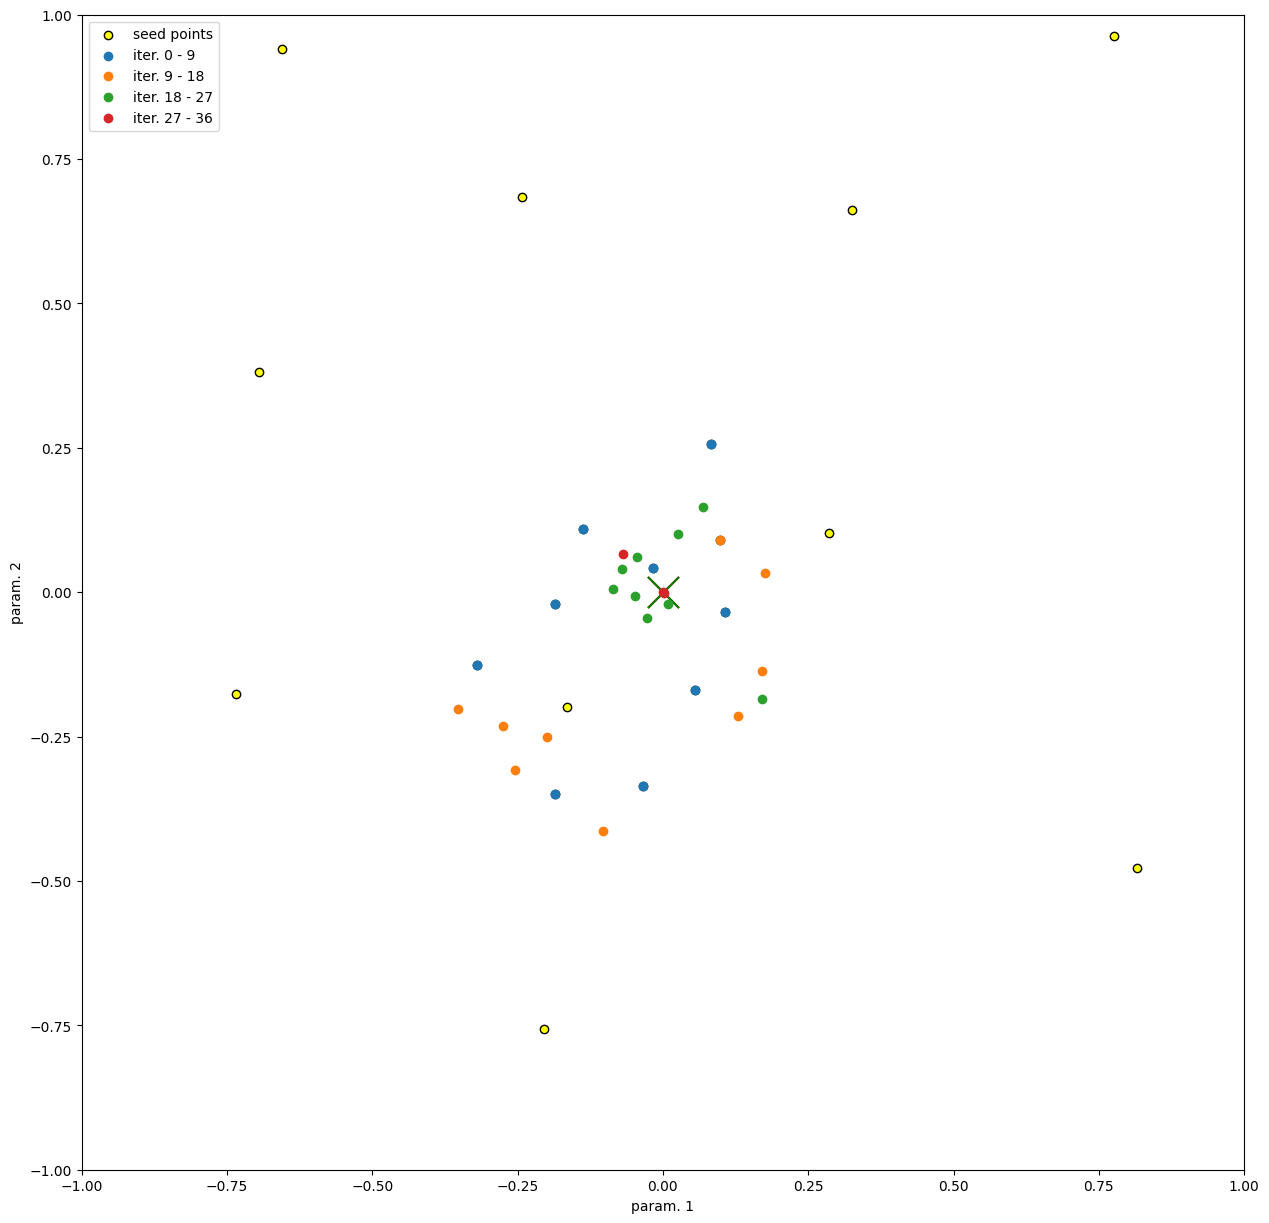

In [32]:
# plot both seed points and exploitation points
fig = plt.figure(figsize=(15, 15))
axes = plt.axes()

# plot true min
plt.scatter(true_params[0], true_params[1], marker="x", s=500, facecolor="red", edgecolors='black')

# plot estimated minimum
plt.scatter(best[0], best[1], marker="x", s=500, facecolor="green", edgecolors='black')

# plot seed
plt.scatter(points[:20, 0], points[:20, 1], marker="o", facecolor="yellow", edgecolors='black', label="seed points")

# plot sampled points
nb_batches_per_scatter = 3
for i in range(0, nb_iterations, nb_batches_per_scatter):
    plt.scatter(
        points[nb_seed_points + i * batch_size : nb_seed_points + (i + nb_batches_per_scatter) * batch_size, 0],
        points[nb_seed_points + i * batch_size : nb_seed_points + (i + nb_batches_per_scatter) * batch_size, 1],
        label="iter. " + str(i * batch_size) + " - " + str((i + nb_batches_per_scatter) * batch_size),
    )

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()